In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from itertools import combinations_with_replacement

In [3]:
import imageio
from IPython import display
import matplotlib.pyplot as plt
from mdp.utils import QuadraticForm, QuadraticFormException
import numpy as np
from scipy.interpolate import interp2d
import scipy.linalg as la
from tqdm import trange

In [4]:
import biosfa

In [5]:
rg = np.random.default_rng(0)

# simulation parameters

In [6]:
num_sequences = 2500
pca_dimension = 64
num_filters = 49

# make image sequences from natural images

In [7]:
# This is an approximation of P. Berkes' code from the complex cell
# properties paper (Berkes + Wiskott, 2005); that code can be found at:
# https://pberkes.github.io/software/slowness_model/index.html
def random_signal(T, n, min_out, max_out, rg):
    # -- random phases and amplitudes
    phi = rg.uniform(2 * np.pi, size=(n, 1))
    a = rg.uniform(size=(1, n))
    # -- fractal combination
    octaves = np.arange(n)
    t = np.linspace(0, 2 * np.pi, num=T)
    out = a @ np.sin(phi + np.outer(octaves, t))
    # -- center, rescale, return
    out = 0.5 + out / n / 2
    out = out * (max_out - min_out) + min_out
    return out.squeeze()

def imagesequence(
    image,
    rg,
    T=100,
    h=16,
    w=16,
    translation_range=75,
    zoom_range=(0.3, 2.0),
    translation_factor=4,
    rotation_factor=8,
    zoom_factor=8,
):
    in_size = np.array(image.shape)
    out_size = np.array([h, w])

    # image interpolation
    interpolator = interp2d(
        np.arange(in_size[1]),
        np.arange(in_size[0]),
        image,
        fill_value=np.nan,
    )

    # loop until we find a valid output
    while True:
        # -- translation signal
        # initial position, at least 4 * w away from edges
        x0 = np.floor(rg.uniform(size=2) * (in_size - 8 * w)) + 4 * w
        # make random motion sequence starting at `x0`
        x = np.zeros(shape=(T, 2)) + x0[None, :]
        if translation_factor > 0:
            x = x0[None, :] + np.stack(
                [
                    random_signal(
                        T,
                        translation_factor,
                        -translation_range,
                        translation_range,
                        rg,
                    )
                    for _ in range(2)
                ],
                axis=1,
            )

        # -- rotation signal
        theta = np.zeros(T)
        if rotation_factor > 0:
            theta = random_signal(T, rotation_factor, 0, 2 * np.pi, rg)
            
        # -- zoom signal
        zoom = np.ones(T)
        if zoom_factor > 0:
            zoom = random_signal(T, zoom_factor, *zoom_range, rg)

        # -- interpolate to produce output
        movie = []
        for t in range(T):
            # corners of FOV after zoom, before rotation + translation
            low = -zoom[t] * out_size
            high = zoom[t] * out_size
            # all points in window
            yt, xt = np.meshgrid(
                np.linspace(low[0], high[0], h),
                np.linspace(low[1], high[1], w),
            )
            # rotate and translate
            zt = (yt + 1j * xt) * np.exp(1j * theta[t])
            yt = (zt.real + x[t, 0]).ravel()
            xt = (zt.imag + x[t, 1]).ravel()
            # get this patch
            patch = [interpolator(xx, yy) for xx, yy in zip(xt, yt)]
            patch = np.array(patch).reshape(h, w)
            # bail if we found nans, i.e. went past the edge
            if np.isnan(patch).any():
                break
            movie.append(patch)
        else:
            # we didn't hit any nans, so return.
            return np.asarray(movie)

In [8]:
# -- load and process ICA images as described in ICA paper.
filenames = sorted(Path("data/").glob("*.tiff"))
images = np.array([imageio.imread(f) for f in filenames])
images = images.astype(float)
# 2x2 block averaging
images = images.reshape(images.shape[0], images.shape[1] // 2, 2, images.shape[2] // 2, 2)
images = images.mean(axis=(2, 4))

In [9]:
# -- make image sequences
sequences = []
for i in trange(num_sequences):
    sequences.append(imagesequence(images[rg.choice(len(images))], rg))
seq = np.concatenate(sequences)
seq -= seq.min()
seq /= seq.max()
seq = seq.astype(np.float32)

100%|██████████| 2500/2500 [1:34:18<00:00,  2.26s/it]


In [10]:
# let's take a look at the beginning of the sequence...
gif = seq[:4096] + 0.0
gif -= gif.min()
gif *= 255.0 / gif.max()
gif_path = '/tmp/biosfa_imseq.gif'
imageio.mimwrite(gif_path, gif.astype(np.uint8), fps=16)
display.Image(gif_path, embed=True, width=200, height=200)

# data preprocessing

In [11]:
# PCA dimension reduction to start
# -- reshape and center
h = seq.reshape(seq.shape[0], -1)
h -= h.mean(axis=0, dtype=float, keepdims=True)

# -- start with dim reduction
hcov = h.T @ h / h.shape[0]
_, D_pca, pcs = la.svd(hcov)
D_pca, pcs = D_pca[:pca_dimension], pcs[:pca_dimension]
# store projection & inverse
D_pca_invsqrt = 1.0 / np.sqrt(D_pca)
Dm = np.diag(D_pca_invsqrt)
W = Dm @ pcs
DW = pcs.T @ np.diag(D_pca)
h = h @ W.T

In [12]:
# -- quadratic expansion
x = np.einsum("ij,ik->ijk", h, h).reshape(h.shape[0], -1)
triu_inds = np.ravel_multi_index(
    np.triu_indices(pca_dimension), (pca_dimension, pca_dimension)
)
x = np.hstack([h, x[:, triu_inds]])
means = x.mean(axis=0, keepdims=True)

# code for visualizing learned subspaces

In [13]:
def get_rfs(a, linear_dim, D=None, means=None, norm=2.0):
    """Extreme stimuli
    Get quadratic form corresponding to a unit's weights
        q(x) = x.T @ H @ x + f @ x + c
    and use MDP to extremize with norm constraint:
        x* =    arg max   q(x)
             ||x||=fixed
    """
    c = 0
    if means is not None:
        c = -np.dot(means.ravel(), a.ravel())
    q, f = a[linear_dim:], a[:linear_dim]
    assert q.shape[0] == (linear_dim * (linear_dim + 1) / 2)
    H = np.zeros((linear_dim, linear_dim))
    for k, (i, j) in enumerate(
        combinations_with_replacement(range(linear_dim), 2)
    ):
        H[i, j] += a[k + linear_dim]
        H[j, i] = H[i, j]
    # Go to PCA space aka WHERE==1
    if D is None:
        D = np.ones(linear_dim)
    D = np.diag(1.0 / np.sqrt(D))
    H = D.T @ H @ D
    f = D.T @ f
    qf = QuadraticForm(H, f, c)
    return qf.get_extrema(norm, 1e-8)

def get_max_rf(a, n, d, DWDm, FOV, means=None, norm=2.0):
    try:
        xp, _ = get_rfs(a, n, d, means=means, norm=norm)
    except QuadraticFormException:
        return np.zeros((FOV, FOV, 3))
    stim = DWDm @ xp.squeeze()
    stim *= np.sign(stim.mean())
    stim -= stim.min()
    stim *= 255.0 / stim.max()
    stim = stim.astype(np.uint8)
    stim = np.stack([stim, stim, stim], axis=-1)
    return stim.reshape(FOV, FOV, 3)

def fimshow(
    ims, ncols, imsize=1, aspect=1.0, impad=0.1, cmap="gray", **subplots_kw
):
    """Plots a gallery of images."""
    nrows = len(ims) // ncols + (len(ims) > len(ims) // ncols * ncols)
    width = aspect * (ncols * imsize + (ncols - 1) * impad / aspect)
    height = nrows * imsize + (nrows - 1) * impad
    fig, ax = plt.subplots(1, 1, figsize=(width, height), **subplots_kw)
    fig.patch.set_alpha(0.0)
    ax.set_xlim([0, width])
    ax.set_ylim([0, height])
    for i, im in enumerate(ims):
        r, c = i // ncols, i % ncols
        extent = (
            aspect * (c * imsize + c * impad / aspect),
            aspect * ((c + 1) * imsize + c * impad / aspect),
            (nrows - r) * imsize + (nrows - r - 1) * impad,
            (nrows - r - 1) * imsize + (nrows - r - 1) * impad,
        )
        ax.imshow(im, cmap=cmap, extent=extent)
    for d in ("top", "left", "bottom", "right"):
        ax.spines[d].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout()
    return fig, ax

def show_max_rfs(subspace, average, stddev):
    xps = [
        get_max_rf(
            v * stddev,
            pca_dimension,
            D_pca,
            DW @ Dm,
            seq.shape[1],
            means=average,
        )
        for v in subspace
    ]
    return fimshow(xps, int(np.ceil(np.sqrt(num_filters))))

# offline SFA via generalized eigenvalue problem solver

In [14]:
Cx = np.cov(x, rowvar=False)
v, u = la.eigh(np.cov(x[1:] + x[:-1], rowvar=False), Cx)
gevp_slow_subspace = u.T[-num_filters:]

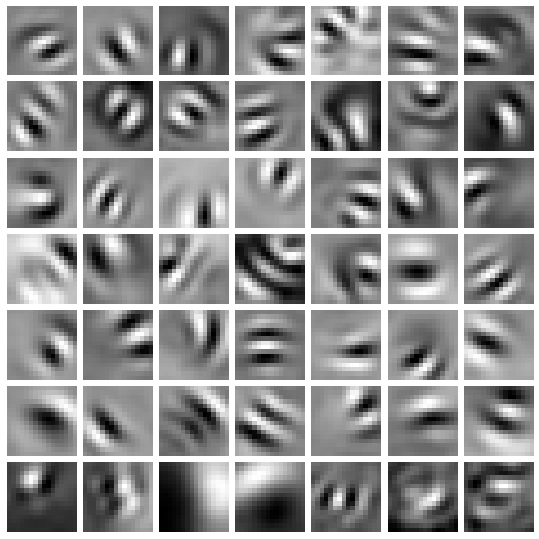

In [15]:
show_max_rfs(gevp_slow_subspace, means, 1); plt.show()

# online BioSFA solution

In [16]:
# Model parameters 
in_c = x.shape[1]
base_eta_w = 1e-5
base_eta_m = 2.0 * base_eta_w
lr_regulator = 5e6
num_epochs = 50

In [17]:
print(num_filters)

49


In [18]:
Minv, W, avg, history = biosfa.fit(x, num_filters, base_eta_w, base_eta_m, lr_regulator, num_epochs, rg=rg)

Epoch 1 / 50


100%|██████████| 249999/249999 [05:07<00:00, 813.65it/s] 

Epoch 2 / 50



100%|██████████| 249999/249999 [03:47<00:00, 1100.90it/s]

Epoch 3 / 50



100%|██████████| 249999/249999 [03:50<00:00, 1086.20it/s]

Epoch 4 / 50



100%|██████████| 249999/249999 [03:35<00:00, 1159.53it/s]

Epoch 5 / 50



100%|██████████| 249999/249999 [03:31<00:00, 1181.49it/s]

Epoch 6 / 50



100%|██████████| 249999/249999 [03:28<00:00, 1196.50it/s]

Epoch 7 / 50



100%|██████████| 249999/249999 [03:28<00:00, 1201.14it/s]

Epoch 8 / 50



100%|██████████| 249999/249999 [03:27<00:00, 1204.50it/s]

Epoch 9 / 50



100%|██████████| 249999/249999 [03:28<00:00, 1197.78it/s]

Epoch 10 / 50



100%|██████████| 249999/249999 [03:28<00:00, 1201.63it/s]

Epoch 11 / 50



100%|██████████| 249999/249999 [03:29<00:00, 1194.08it/s]

Epoch 12 / 50



100%|██████████| 249999/249999 [03:28<00:00, 1199.67it/s]

Epoch 13 / 50



100%|██████████| 249999/249999 [03:33<00:00, 1169.15it/s]

Epoch 14 / 50



100%|██████████| 249999/249999 [03:26<00:00, 1208.04it/s]

Epoch 15 / 50



100%|██████████| 249999/249999 [03:26<00:00, 1211.51it/s]

Epoch 16 / 50



100%|██████████| 249999/249999 [03:28<00:00, 1197.63it/s]

Epoch 17 / 50



100%|██████████| 249999/249999 [03:27<00:00, 1205.92it/s]

Epoch 18 / 50



100%|██████████| 249999/249999 [03:27<00:00, 1207.45it/s]

Epoch 19 / 50



100%|██████████| 249999/249999 [03:28<00:00, 1198.87it/s]

Epoch 20 / 50



100%|██████████| 249999/249999 [03:34<00:00, 1166.15it/s]

Epoch 21 / 50



100%|██████████| 249999/249999 [03:30<00:00, 1186.11it/s]

Epoch 22 / 50



100%|██████████| 249999/249999 [03:28<00:00, 1200.61it/s]

Epoch 23 / 50



100%|██████████| 249999/249999 [03:17<00:00, 1268.44it/s]

Epoch 24 / 50



100%|██████████| 249999/249999 [2:28:29<00:00, 28.06it/s]      


Epoch 25 / 50


100%|██████████| 249999/249999 [03:01<00:00, 1375.01it/s]

Epoch 26 / 50



100%|██████████| 249999/249999 [02:52<00:00, 1452.13it/s]

Epoch 27 / 50



100%|██████████| 249999/249999 [02:54<00:00, 1436.23it/s]

Epoch 28 / 50



100%|██████████| 249999/249999 [7:03:32<00:00,  9.84it/s]       

Epoch 29 / 50



100%|██████████| 249999/249999 [03:57<00:00, 1054.81it/s]

Epoch 30 / 50



100%|██████████| 249999/249999 [03:29<00:00, 1194.79it/s]

Epoch 31 / 50



100%|██████████| 249999/249999 [03:20<00:00, 1243.79it/s]

Epoch 32 / 50



100%|██████████| 249999/249999 [03:31<00:00, 1181.96it/s]

Epoch 33 / 50



100%|██████████| 249999/249999 [03:37<00:00, 1146.91it/s]

Epoch 34 / 50



100%|██████████| 249999/249999 [03:33<00:00, 1172.70it/s]

Epoch 35 / 50



100%|██████████| 249999/249999 [03:48<00:00, 1093.59it/s]

Epoch 36 / 50



100%|██████████| 249999/249999 [04:04<00:00, 1022.29it/s]

Epoch 37 / 50



100%|██████████| 249999/249999 [03:49<00:00, 1091.28it/s]

Epoch 38 / 50



100%|██████████| 249999/249999 [03:37<00:00, 1147.19it/s]

Epoch 39 / 50



100%|██████████| 249999/249999 [03:26<00:00, 1208.65it/s]

Epoch 40 / 50



100%|██████████| 249999/249999 [03:25<00:00, 1215.96it/s]

Epoch 41 / 50



100%|██████████| 249999/249999 [03:27<00:00, 1204.46it/s]

Epoch 42 / 50



100%|██████████| 249999/249999 [03:51<00:00, 1079.83it/s]

Epoch 43 / 50



100%|██████████| 249999/249999 [03:38<00:00, 1142.79it/s]

Epoch 44 / 50



100%|██████████| 249999/249999 [03:37<00:00, 1149.39it/s]

Epoch 45 / 50



100%|██████████| 249999/249999 [03:26<00:00, 1210.97it/s]

Epoch 46 / 50



100%|██████████| 249999/249999 [03:21<00:00, 1242.59it/s]

Epoch 47 / 50



100%|██████████| 249999/249999 [03:25<00:00, 1213.85it/s]

Epoch 48 / 50



100%|██████████| 249999/249999 [03:21<00:00, 1239.11it/s]

Epoch 49 / 50



100%|██████████| 249999/249999 [03:21<00:00, 1242.61it/s]

Epoch 50 / 50



100%|██████████| 249999/249999 [03:20<00:00, 1244.67it/s]


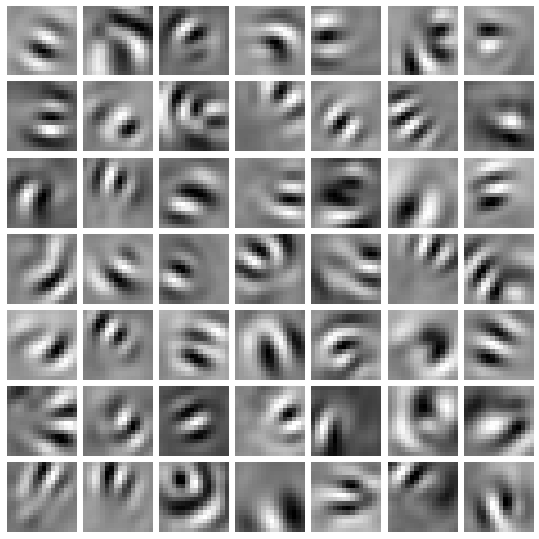

In [19]:
# visualize filters
show_max_rfs(Minv @ W, avg, 1); plt.show()

In [23]:
# -- convergence plot
# whitened derivative covariance
Cdx = np.cov(x[1:] - x[:-1], rowvar=False)
duu, dww, dvv = np.linalg.svd(Cx)
isqrtxtx = duu @ np.diag(1.0 / np.sqrt(dww)) @ dvv
Cwdx = isqrtxtx.T @ Cdx @ isqrtxtx
# offline slowness
gevp_s = np.trace(gevp_slow_subspace @ Cwdx @ gevp_slow_subspace.T) / np.trace(gevp_slow_subspace @ gevp_slow_subspace.T)

# online slowness history
slowness_errors = []
t, Minv_t, W_t = history
for Minv_, W_ in zip(Minv_t, W_t):
    F = Minv_ @ W_
    # enforce orthogonality constraint
    fu, fw, fv = la.svd(F @ Cx @ F.T)
    orth_F = fu @ np.diag(1.0 / np.sqrt(fw)) @ fv @ F
    s = np.trace(orth_F @ Cwdx @ orth_F.T) / np.trace(orth_F @ orth_F.T)
    slowness_errors.append(s - gevp_s)

<ipython-input-23-5efb7e920f8a>:17: RuntimeWarning: divide by zero encountered in true_divide
  orth_F = fu @ np.diag(1.0 / np.sqrt(fw)) @ fv @ F
<ipython-input-23-5efb7e920f8a>:17: RuntimeWarning: invalid value encountered in matmul
  orth_F = fu @ np.diag(1.0 / np.sqrt(fw)) @ fv @ F


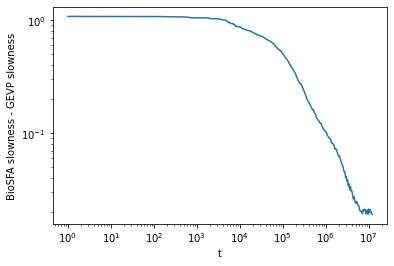

In [28]:
plt.loglog(t, slowness_errors)
plt.ylabel("BioSFA slowness - GEVP slowness")
plt.xlabel("t")
plt.show()